In [1]:
%matplotlib notebook

# 5) IFU line fitting

In this tutorial, we are going to fit the emission lines on the spaxels from the masks, we defined in the [previous tutorial](https://lime-stable.readthedocs.io/en/latest/tutorials/4_IFU_Spatial_Masking.html#).
You can download this tutorial as a [python script](https://github.com/Vital-Fernandez/lime/blob/master/examples/example5_IFU_fitting.py) and a [jupyter notebook](https://github.com/Vital-Fernandez/lime/blob/master/docs/source/tutorials/5_IFU_Line_Fitting.ipynb).


Let’s start by importing the libraries we need:

In [2]:
# This try import is only necessary for the developper to compile the online documentation from this notebook
try:
    import lime
except ImportError:
    import sys
    sys.path.append('../../../src')
    import lime
    
from pathlib import Path
from astropy.io import fits
from astropy.wcs import WCS

Let's define the inputs and outputs paths

In [3]:
# State the data location
cfg_file = './sample_data/manga.cfg'
cube_file = Path('./sample_data/manga-8626-12704-LOGCUBE.fits.gz')
bands_file_1 = Path('./sample_data/SHOC579_MASK1_bands.txt')
spatial_mask_file = Path('./sample_data/SHOC579_mask.fits')
output_lines_log_file = Path('./sample_data/SHOC579_log.fits')

Now we read the observation and treatment configuration

In [4]:
# Load the configuration file:
obs_cfg = lime.load_cfg(cfg_file)

# Observation properties
z_obj = obs_cfg['SHOC579']['redshift']
norm_flux = obs_cfg['SHOC579']['norm_flux']

With this information, we can load the scientific data and define the ``lime.Cube`` object:

In [5]:
# Open the MANGA cube fits file
with fits.open(cube_file) as hdul:
    wave = hdul['WAVE'].data
    flux_cube = hdul['FLUX'].data * norm_flux
    hdr = hdul['FLUX'].header

# Define a LiMe cube object
shoc579 = lime.Cube(wave, flux_cube, redshift=z_obj, norm_flux=norm_flux)

At this point, you have diferent strategies to fit lines on this IFU data set. For example, you can recover the spectrum from a spaxel using the flux cube coordinates.

<div class="alert alert-info">

**Please remember:** This is a [numpy array](https://numpy.org/devdocs/_images/np_matrix_indexing.png), the first and second indeces correspond to the vertical and horizontal axis respectively. These are the spatial axis on an IFU observation. The third index corresponds to the cube depth axis or the IFU wavelength array. The origin in this numerical array is located on the  upper-left-front corner on the 3D array.

</div>

In [6]:
# Extract one spaxel (idx Y, idx X):
spaxel = shoc579.get_spaxel(39, 40)

We can use the ``.fit.frame`` function we visisted in the [3rd tutorial](https://lime-stable.readthedocs.io/en/latest/tutorials/3_CompleteSpectrumFitting.html):

In [7]:
spaxel.fit.frame(bands_file_1, obs_cfg['MASK_1_line_fitting'], progress_output='bar', line_detection=False)

[==========] 100% of 36 lines

The fitted profiles can be displayed using the ``.plot.spectrum`` function:

<IPython.core.display.Javascript object>


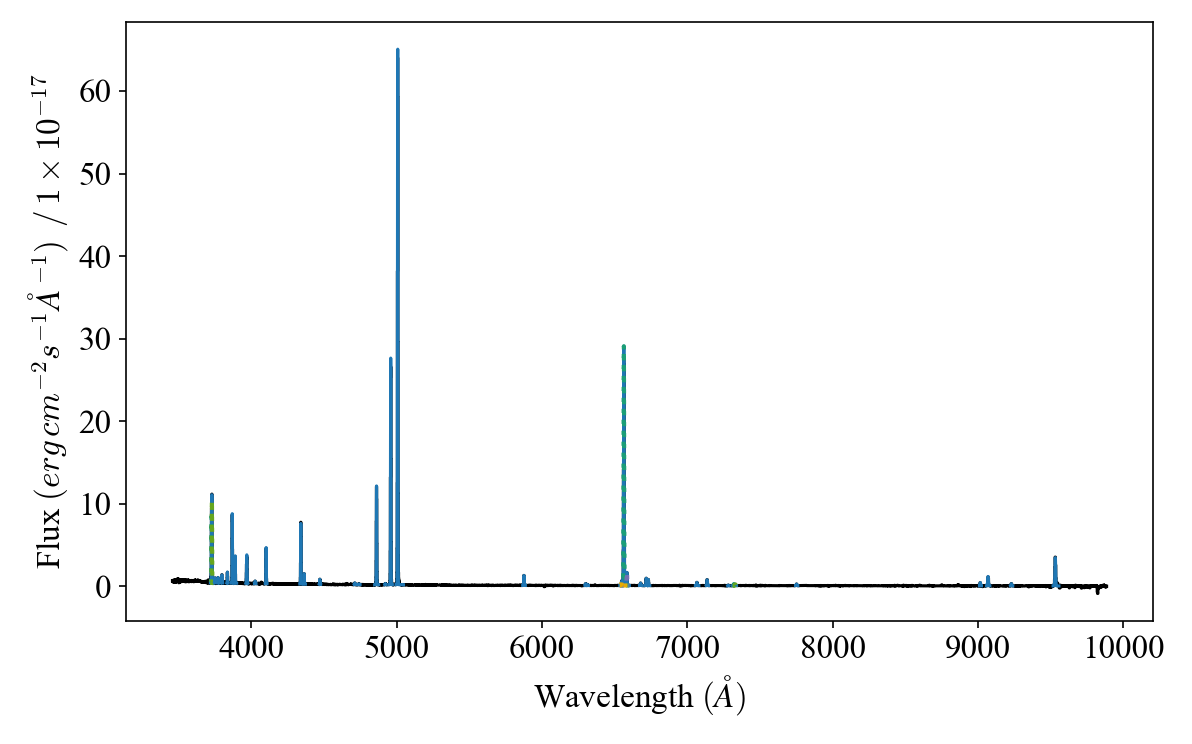

In [8]:
spaxel.plot.spectrum(include_fits=True, rest_frame=True)

To treat serveral spaxels in a efficient workflow, you can use the ``.fit.spatial_mask`` function:

In [11]:
# Fit the lines from all the masks in the input .fits file
shoc579.fit.spatial_mask(spatial_mask_file, fit_conf=obs_cfg, line_detection=True, output_log=output_lines_log_file)



Spatial mask 1/3) MASK_0 (33 spaxels)
[==========] 100% of 33 spaxels

Spatial mask 2/3) MASK_1 (97 spaxels)
[==========] 100% of 97 spaxels

Spatial mask 3/3) MASK_2 (97 spaxels)
[========= ] 98% of 97 spaxels

LiMe WARNING: Ne3_3869A failure to measure the non-parametric FWHM


[==========] 100% of 97 spaxels

You can adjust the ``.fit.spatial_mask`` measurements with these arguments:

* The ``mask_name_list=`` argument constrains the masks to explore from the ``spatial_mask_file`` (the default is all of them).
* The ``fit_conf=obs_cfg`` argument assumes that there are several sections, one for spatial mask, with the **[MASK-NAME_line_fitting]** naming style. Using this formating you can apply a different fitting configuration for each mask. In general you will start with the spaxels with the highest S/N and more complex line profiles and move towards simpler configurations. You can see this on the input [manga.cfg file](https://github.com/Vital-Fernandez/lime/blob/master/examples/sample_data/manga.cfg).
* This function can only save the measurements as a *.fits* file. This file is specified using the ``output_log=output_lines_log_file``. Each page on the *.fits* file corresponds to a spaxel. The default page name is **idxY-idxX_LINESLOG**. You can change the default extension suffix with the ``log_ext_suffix='_LINESLOG'`` argument.
* The ``n_save=100`` argument states after how many spaxels the *.fits* file with the measurements is saved on the hard drive. Additionally, the *.fits* file is always saved at the last spaxel of a mask.

<div class="alert alert-info">

**Please remember:** The ``.fit.spatial_mask`` function cannot add or update measurements on an existing *.fits* file. It will always overwrite an existing file on the provided ``output_log`` path.

</div>

Finally, you can visualize the fitted profiles on the output *.fits* using the ``.plot.cube`` function:

a string value was expected. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


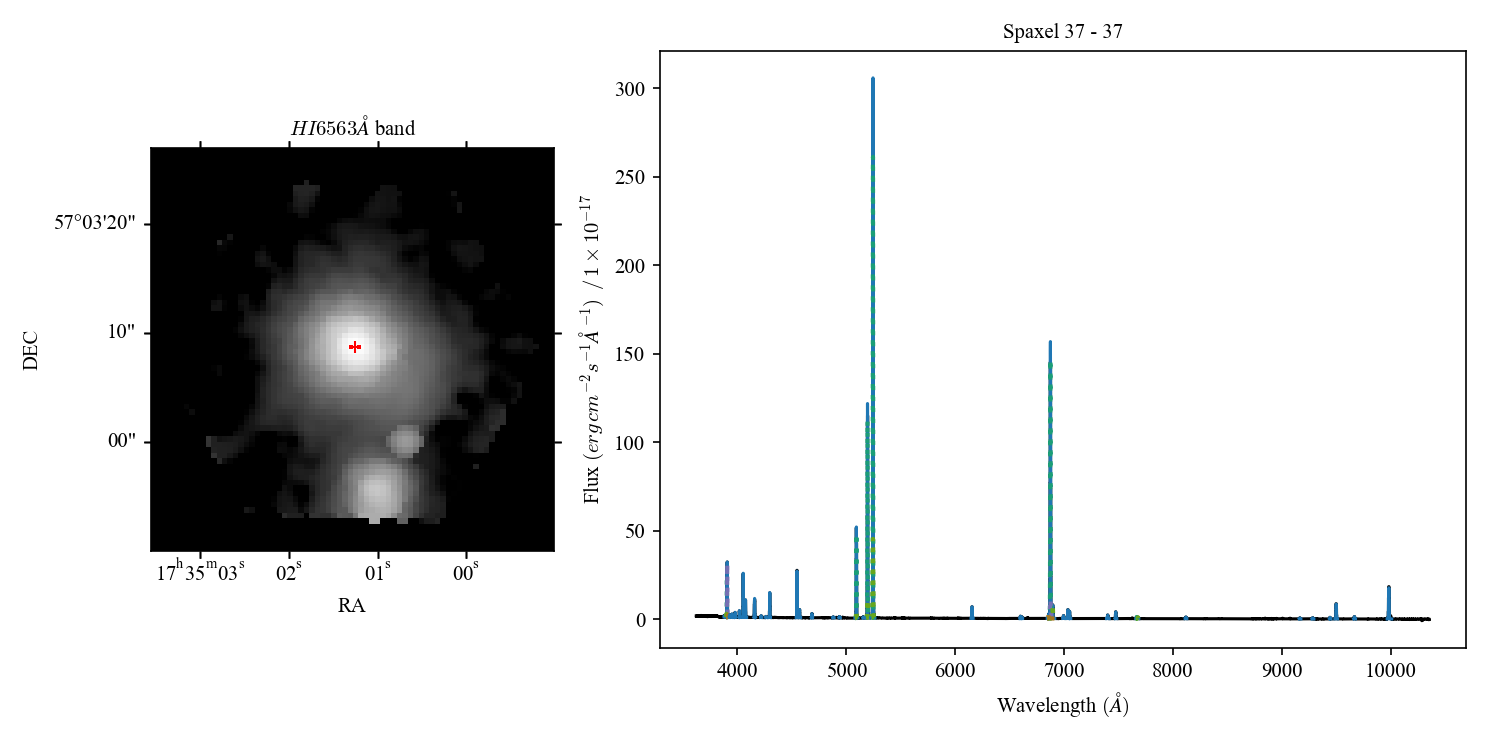

In [13]:
shoc579.check.cube('H1_6563A', wcs=WCS(hdr), lines_log_address=output_lines_log_file)

In the next tutorial, we shall see how you can use $LiMe$ functions to extract the measurements from a spatial lines log such as the one we just generated.